CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [ ]:
!pip install captum

In [39]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [40]:
df = pd.read_csv('hdb_price_prediction.csv')

df2020val = df[df['year']==2020]
df2021test = df[df['year']==2021]
df2019andbeforetrain = df[df['year']<=2019]

df2020val = df2020val.drop(['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range'], axis=1)
df2021test = df2021test.drop(['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range'], axis=1)
df2019andbeforetrain = df2019andbeforetrain.drop(['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range'], axis=1)

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [41]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class B3Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.B3_stack=nn.Sequential(
        nn.Linear(6, 5),
        nn.ReLU(),
        nn.Linear(5, 5),
        nn.ReLU(),
        nn.Linear(5, 5),
        nn.ReLU(),
        nn.Linear(5, 1)
        )

    def forward(self, x):
        logits = self.B3_stack(x)
        return logits
    
def train(model_inp, train_iter, num_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=0.001)
    num_epochs = num_epochs
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for batch, (inputs, labels) in enumerate(train_iter):
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 10 == 0:    
            print('Epoch [%d]/[%d] running MSE loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        if early_stopper.early_stop(running_loss): 
            print("Stopped at epoch " + str(epoch + 1))
            print("Done!")
            break
        running_loss = 0.0

def train_load_save_model(model_obj, model_path, train_iter, num_epochs):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj, train_iter, num_epochs)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [42]:
from os import path

torch.manual_seed(SEED)
early_stopper = EarlyStopper(patience=5, min_delta=0)

df2019andbeforetrainX = df2019andbeforetrain.drop('resale_price', axis=1)
df2019andbeforetrainY = df2019andbeforetrain.drop(["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"], axis=1)
df2021testX = df2021test.drop('resale_price', axis=1)
df2021testY = df2021test.drop(["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"], axis=1)

df2019andbeforetrainX = torch.tensor(df2019andbeforetrainX.to_numpy()).float()
df2019andbeforetrainY = torch.tensor(df2019andbeforetrainY.to_numpy()).view(-1, 1).float()

df2021testX = torch.tensor(df2021testX.to_numpy()).float()
df2021testY = torch.tensor(df2021testY.to_numpy()).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(df2019andbeforetrainX, df2019andbeforetrainY)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=1024, shuffle=True)

# batch_size = 1024
    
model = B3Model()
model.train()
        
num_epochs = 2000
SAVED_MODEL_PATH = 'models/B3_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH, train_iter, num_epochs)

Epoch [1]/[2000] running MSE loss across all batches: 13629151969280.000
Epoch [11]/[2000] running MSE loss across all batches: 12914372132864.000
Epoch [21]/[2000] running MSE loss across all batches: 6939391008768.000
Epoch [31]/[2000] running MSE loss across all batches: 1315887650816.000
Epoch [41]/[2000] running MSE loss across all batches: 999632215040.000
Epoch [51]/[2000] running MSE loss across all batches: 984400417792.000
Epoch [61]/[2000] running MSE loss across all batches: 966730207232.000
Epoch [71]/[2000] running MSE loss across all batches: 947376161792.000
Epoch [81]/[2000] running MSE loss across all batches: 926846841856.000
Epoch [91]/[2000] running MSE loss across all batches: 903925410816.000
Epoch [101]/[2000] running MSE loss across all batches: 879889949696.000
Epoch [111]/[2000] running MSE loss across all batches: 854408491008.000
Epoch [121]/[2000] running MSE loss across all batches: 831364130816.000
Epoch [131]/[2000] running MSE loss across all batches: 

In [44]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sl_attr_test = sl.attribute(df2021testX[:1000])
ixg_attr_test = ixg.attribute(df2021testX[:1000])
ig_attr_test = ig.attribute(df2021testX[:1000], n_steps=50)
gs_attr_test = gs.attribute(df2021testX[:1000], df2019andbeforetrainX)
fa_attr_test = fa.attribute(df2021testX[:1000])

C:\Users\Gareth Thong\anaconda3\envs\nnb3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


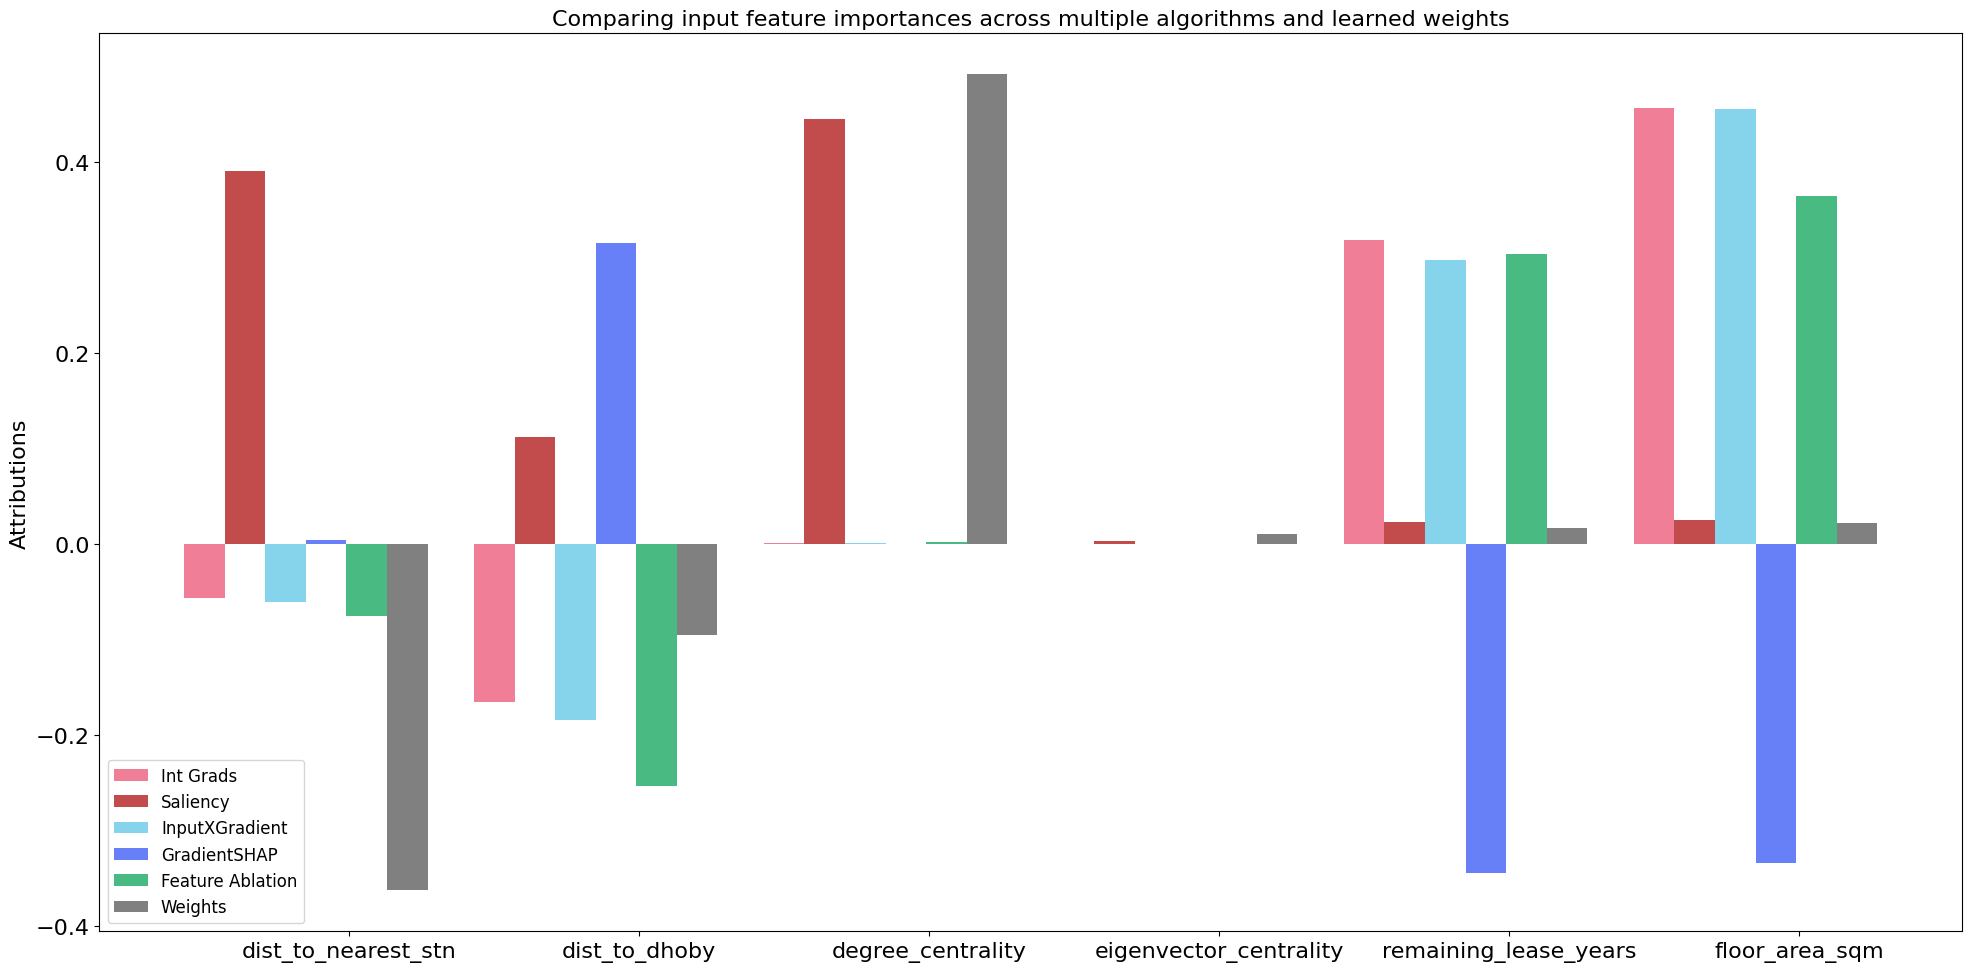

In [45]:
# prepare attributions for visualization
import matplotlib.pyplot as plt

feature_names = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

x_axis_data = np.arange(df2021testX[:1000].shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.B3_stack[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Saliency','InputXGradient', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, sl_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ixg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [46]:
from sklearn import preprocessing

torch.manual_seed(SEED)
early_stopper = EarlyStopper(patience=5, min_delta=0)

standard_scaler = preprocessing.StandardScaler()

df2019andbeforetrainX = df2019andbeforetrain.drop('resale_price', axis=1)
df2019andbeforetrainY = df2019andbeforetrain.drop(["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"], axis=1)
df2021testX = df2021test.drop('resale_price', axis=1)
df2021testY = df2021test.drop(["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"], axis=1)

df2019andbeforetrainXscaled = standard_scaler.fit_transform(df2019andbeforetrainX)
df2021testXscaled = standard_scaler.transform(df2021testX)
df2019andbeforetrainYscaled = standard_scaler.fit_transform(df2019andbeforetrainY)
df2021testYscaled = standard_scaler.transform(df2021testY)

df2019andbeforetrainXscaled = torch.tensor(df2019andbeforetrainXscaled).float()
df2019andbeforetrainYscaled = torch.tensor(df2019andbeforetrainYscaled).view(-1, 1).float()

df2021testXscaled = torch.tensor(df2021testXscaled).float()
df2021testYscaled = torch.tensor(df2021testYscaled).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(df2019andbeforetrainXscaled, df2019andbeforetrainYscaled)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=1024, shuffle=True)

# batch_size = 1024
    
modelscaled = B3Model()
modelscaled.train()
        
num_epochs = 2000
SAVED_MODEL_PATH = 'models/B3_model_scaled.pt'
train_load_save_model(modelscaled, SAVED_MODEL_PATH, train_iter, num_epochs)

Epoch [1]/[2000] running MSE loss across all batches: 64.506
Epoch [11]/[2000] running MSE loss across all batches: 9.183
Epoch [21]/[2000] running MSE loss across all batches: 8.600
Epoch [31]/[2000] running MSE loss across all batches: 8.278
Epoch [41]/[2000] running MSE loss across all batches: 8.112
Epoch [51]/[2000] running MSE loss across all batches: 8.058
Epoch [61]/[2000] running MSE loss across all batches: 8.053
Epoch [71]/[2000] running MSE loss across all batches: 8.017
Epoch [81]/[2000] running MSE loss across all batches: 8.008
Stopped at epoch 83
Done!
Finished training the model. Saving the model to the path: models/B3_model_scaled.pt


In [47]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sl_attr_test = sl.attribute(df2021testXscaled[:1000])
ixg_attr_test = ixg.attribute(df2021testXscaled[:1000])
ig_attr_test = ig.attribute(df2021testXscaled[:1000], n_steps=50)
gs_attr_test = gs.attribute(df2021testXscaled[:1000], df2019andbeforetrainXscaled)
fa_attr_test = fa.attribute(df2021testXscaled[:1000])

C:\Users\Gareth Thong\anaconda3\envs\nnb3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


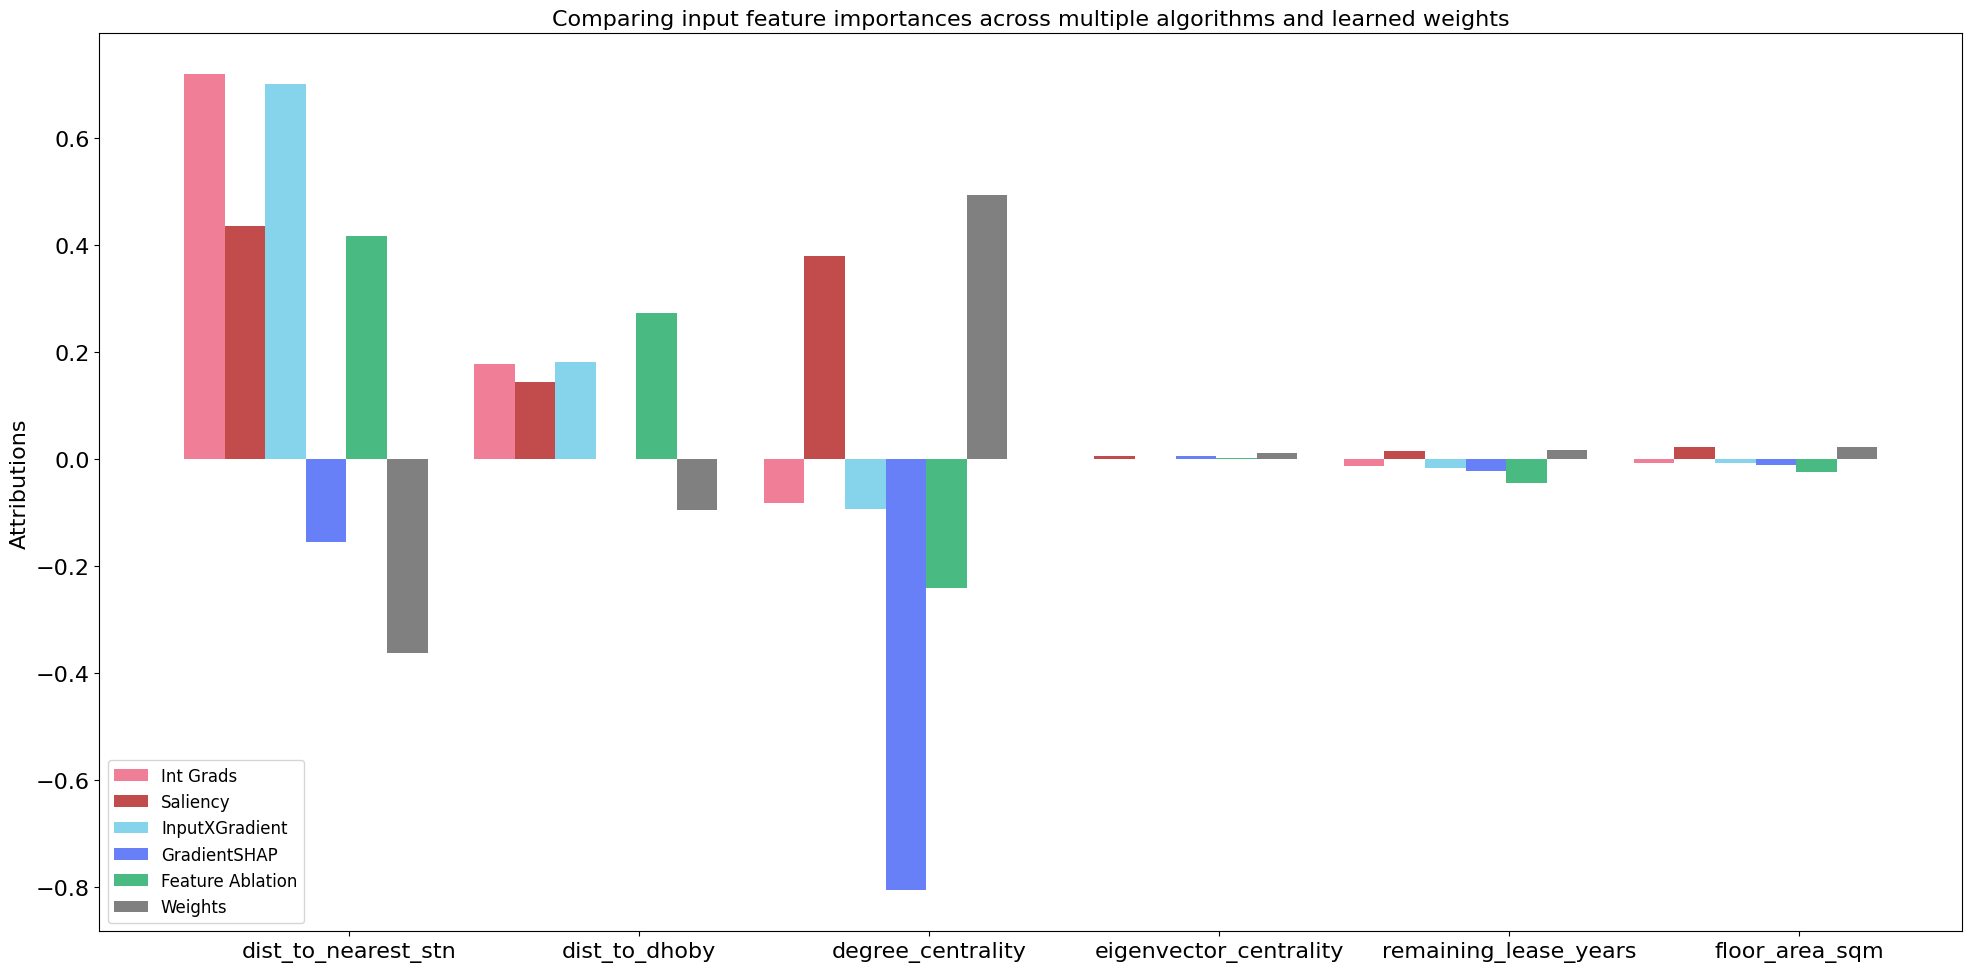

In [48]:
feature_names = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

x_axis_data = np.arange(df2021testXscaled[:1000].shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.B3_stack[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Saliency','InputXGradient', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, sl_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ixg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)

GradientSHAP:
    
Unscaled: 
High positive attributions: dist_to_dhoby
High negative attributions: remaining_lease_years, floor_area_sqm
Attribution score around 0: dist_to_nearest_stn, degree_centrality, eigenvector_centrality
    
Scaled:
High negative attributions: degree_centrality
Small negative attributions: dist_to_nearest_stn
Attribution score around 0: dist_to_dhoby, eigenvector_centrality, remaining_lease_years, floor_area_sqm
    
Explanation:
Baseline: The graph is being plotted based on the mean of the (scaled and unscaled) test attribute values here. 
Using the mean of the test attribute values for degree_centrality might not make sense, as degree_centrality
is closer to being a categorical than a continuous variable, since the number of MRT lines connected to the 
MRT station closest to the flat are discrete integers rather than floats. Taking into account that the number
of connected MRT lines generally does not exceed 4 or 5 (based on the Singapore MRT system), this 
makes it even more like a categorical rather than a continuous variable given the limited value space. 
The GradientSHAP values for degree_centrality may hence be erratic as degree_centrality may not 
be a suitable feature for this task.

When unscaled, the remaining_lease_years and floor_area_sqm have very negative attributions, but receive an attribution
score around 0 instead when training on a scaled dataset. This is because remaining_lease_years and floor_area values have
a large magnitude when unscaled, when compared to the rest of the input features. Their impact on the model could have
been overstated in the model trained on the unscaled dataset. The importance given by the model trained on the unscaled
dataset to other input features would have been diminished as a result. This also explains why the GradientSHAP values
become close to 0 for remaining_lease_years and floor_area_sqm for the model trained on the scaled dataset, as their
impact on the model would have been normalised with the rest of the input features.

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


Both Saliency and IG are gradient-based approaches, and compute the gradients of the output with respect to input when determining how important a feature is to the model. This would have resulted in similar scores.

> Why did Input x Gradients give the same attribution scores as IG?


This is because both Input X Gradients and IG calculate gradients using a similar baseline reference.